In [1]:
#!/usr/bin/env python3
"""
plot_performance_results.ipynb

Reads JSON performance result files (from 'performance_results') for two experiment types:
    - grid_scaling
    - landscape_prop

Generates two separate charts plotting the results for each experiment type.
These include: baseline, refactoring_1, refactoring_2, and refactoring_3.
The charts show the average time taken for each approach, with error bars indicating the standard deviation.
The charts are displayed using Matplotlib.
"""

# ─── Cell #1: Imports and Global Constants ─────────────────────────────────────
import os
import json
import glob
import statistics
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns  # Using seaborn for enhanced aesthetics

# Set a sleek, academic style with seaborn and update matplotlib settings
sns.set_theme(style="ticks", context="talk", palette="deep")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'lines.linewidth': 2.5,
    'grid.linestyle': '--',
    'grid.linewidth': 0.8,
})
# Base path where the results are located
BASE_PATH = "."


In [2]:
# ─── Cell #2: Data Parsing Functions (With Debug Prints) ──────────────────────

def parse_landscape_prop_results(folder_path: str, debug: bool = False) -> Dict[str, List[Tuple[float, float, float]]]:
    """
    Parses JSON files matching '*_landscape_prop.json' in 'folder_path'.

    Each file is treated as one approach (e.g. 'BASELINE', 'REFACTOR_1', etc.).
    For each dimension (like '40x40') and land proportion (e.g. '0.10'),
    we compute (mean_time, st_dev, land_prop).

    Args:
        folder_path (str): Directory containing the JSON files for the experiment.
        debug (bool): If True, prints debugging information about times, mean, st.dev.

    Returns:
        Dict[str, List[Tuple[float, float, float]]]:
            Keys are approach names (e.g., 'BASELINE'),
            Values are lists of (mean_time, std_time, land_prop).
    """
    results_dict: Dict[str, List[Tuple[float, float, float]]] = {}

    # Find files that match the pattern
    json_files = glob.glob(os.path.join(folder_path, "*_landscape_prop.json"))
    if debug:
        print(f"[DEBUG] parse_landscape_prop_results -> Found {len(json_files)} files in {folder_path}")

    for file_path in json_files:
        filename = os.path.basename(file_path)
        approach_name = filename.split("_landscape_prop.json")[0]
        if approach_name not in results_dict:
            results_dict[approach_name] = []
        with open(file_path, "r") as f:
            data = json.load(f)
        for dimension_key, proportions_dict in data.get("results", {}).items():
            for prop_str, times in proportions_dict.items():
                land_prop = float(prop_str)
                mean_time = statistics.mean(times)
                std_time = statistics.stdev(times) if len(times) > 1 else 0.0
                if debug:
                    print(f"  [DEBUG] approach: {approach_name}, dimension: {dimension_key}, "
                          f"prop: {prop_str}, times={times}")
                    print(f"    mean_time={mean_time}, std_time={std_time}")
                results_dict[approach_name].append((mean_time, std_time, land_prop))
    return results_dict


def parse_grid_scaling_results(folder_path: str, debug: bool = False) -> Dict[str, List[Tuple[float, float, int]]]:
    """
    Parses JSON files matching '*_grid_scaling.json' in 'folder_path'.

    Each file is treated as one approach. For each dimension (like '160x160'),
    we compute (mean_time, st_dev, grid_size).

    Args:
        folder_path (str): Directory containing the JSON files for the experiment.
        debug (bool): If True, prints debugging information about times, mean, st.dev.

    Returns:
        Dict[str, List[Tuple[float, float, int]]]:
            Keys are approach names,
            Values are lists of (mean_time, std_time, grid_size).
    """
    results_dict: Dict[str, List[Tuple[float, float, int]]] = {}
    json_files = glob.glob(os.path.join(folder_path, "*_grid_scaling.json"))
    if debug:
        print(f"[DEBUG] parse_grid_scaling_results -> Found {len(json_files)} files in {folder_path}")

    for file_path in json_files:
        filename = os.path.basename(file_path)
        approach_name = filename.split("_grid_scaling.json")[0]
        if approach_name not in results_dict:
            results_dict[approach_name] = []
        with open(file_path, "r") as f:
            data = json.load(f)
        for dimension_key, prop_dict in data.get("results", {}).items():
            grid_size = int(dimension_key.split("x")[0])
            for _, times in prop_dict.items():
                mean_time = statistics.mean(times)
                std_time  = statistics.stdev(times) if len(times) > 1 else 0.0
                if debug:
                    print(f"  [DEBUG] approach: {approach_name}, dimension: {dimension_key}, times={times}")
                    print(f"    mean_time={mean_time}, std_time={std_time}")
                results_dict[approach_name].append((mean_time, std_time, grid_size))
    return results_dict


In [3]:
# ─── Cell #3: Plotting Functions With Enhanced Aesthetics ─────────

def plot_landscape_prop_results(
    data: Dict[str, List[Tuple[float, float, float]]]
) -> None:
    """
    Plots the data for the 'landscape_prop' experiment on a single chart,
    showing a shaded st.dev band between (mean - std) and (mean + std).

    x-axis: landscape proportion
    y-axis: average time

    The legend is labeled with an aggregate st.dev measure (average)
    for each approach.
    """
    plt.figure()
    # Generate a color palette for the approaches
    approaches = sorted(data.keys())
    colors = sns.color_palette("deep", n_colors=len(approaches))
    
    for idx, approach_name in enumerate(approaches):
        tuples_list = data[approach_name]
        # Sort by landscape proportion
        sorted_list = sorted(tuples_list, key=lambda x: x[2])
        mean_times  = [x[0] for x in sorted_list]
        std_times   = [x[1] for x in sorted_list]
        land_props  = [x[2] for x in sorted_list]
        lower_bounds = [m - s for m, s in zip(mean_times, std_times)]
        upper_bounds = [m + s for m, s in zip(mean_times, std_times)]
        # Compute aggregate std for legend
        avg_std = sum(std_times) / len(std_times) if std_times else 0.0
        legend_label = f"{approach_name} (avg st.dev={avg_std:.3f})"
        
        # Plot main line with dedicated color and markersize
        line_handle, = plt.plot(
            land_props,
            mean_times,
            '-o',
            markersize=8,
            label=legend_label,
            color=colors[idx]
        )
        # Fill between the error bounds
        plt.fill_between(
            land_props,
            lower_bounds,
            upper_bounds,
            alpha=0.3,
            color=colors[idx]
        )

    plt.title("Landscape Prop Experiment: Land Proportion vs. Time (± Std Dev)")
    plt.xlabel("Landscape Proportion")
    plt.ylabel("Average Time (seconds)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.minorticks_on()
    sns.despine(trim=True)
    plt.tight_layout()


def plot_grid_scaling_results(
    data: Dict[str, List[Tuple[float, float, int]]]
) -> None:
    """
    Plots the data for the 'grid_scaling' experiment on a single chart,
    showing a shaded st.dev band between (mean - std) and (mean + std).

    x-axis: grid dimension
    y-axis: average time

    The legend is labeled with an aggregate st.dev measure (average)
    for each approach.
    """
    plt.figure()
    approaches = sorted(data.keys())
    colors = sns.color_palette("deep", n_colors=len(approaches))
    
    for idx, approach_name in enumerate(approaches):
        tuples_list = data[approach_name]
        # Sort by grid size
        sorted_list = sorted(tuples_list, key=lambda x: x[2])
        mean_times  = [x[0] for x in sorted_list]
        std_times   = [x[1] for x in sorted_list]
        grid_sizes  = [x[2] for x in sorted_list]
        lower_bounds = [m - s for m, s in zip(mean_times, std_times)]
        upper_bounds = [m + s for m, s in zip(mean_times, std_times)]
        
        avg_std = sum(std_times) / len(std_times) if std_times else 0.0
        legend_label = f"{approach_name} (avg st.dev={avg_std:.3f})"
        
        line_handle, = plt.plot(
            grid_sizes,
            mean_times,
            '-o',
            markersize=8,
            label=legend_label,
            color=colors[idx]
        )
        plt.fill_between(
            grid_sizes,
            lower_bounds,
            upper_bounds,
            alpha=0.3,
            color=colors[idx]
        )

    plt.title("Grid Scaling Experiment: Grid Dimension vs. Time (± Std Dev)")
    plt.xlabel("Grid Dimension")
    plt.ylabel("Average Time (seconds)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.minorticks_on()
    sns.despine(trim=True)
    plt.tight_layout()


[DEBUG] parse_landscape_prop_results -> Found 4 files in ./landscape_prop
  [DEBUG] approach: REFACTOR_2, dimension: 160x160, prop: 0.10, times=[1.2690824380842969, 1.2255854499526322, 1.223735658917576]
    mean_time=1.239467848984835, std_time=0.02566365810569133
  [DEBUG] approach: REFACTOR_2, dimension: 160x160, prop: 0.20, times=[1.6380577080417424, 1.6129176950780675, 1.6003691690275446]
    mean_time=1.6171148573824514, std_time=0.01919162895152951
  [DEBUG] approach: REFACTOR_2, dimension: 160x160, prop: 0.40, times=[2.899421461042948, 2.882599466945976, 2.8976110139628872]
    mean_time=2.8932106473172703, std_time=0.009234028985850823
  [DEBUG] approach: REFACTOR_2, dimension: 160x160, prop: 0.80, times=[4.444876551046036, 4.413037664955482, 4.420942111988552]
    mean_time=4.426285442663357, std_time=0.016578361013594046
  [DEBUG] approach: BASELINE, dimension: 160x160, prop: 0.10, times=[7.224946654983796, 7.037105484982021, 6.667331847012974]
    mean_time=6.97646132899293

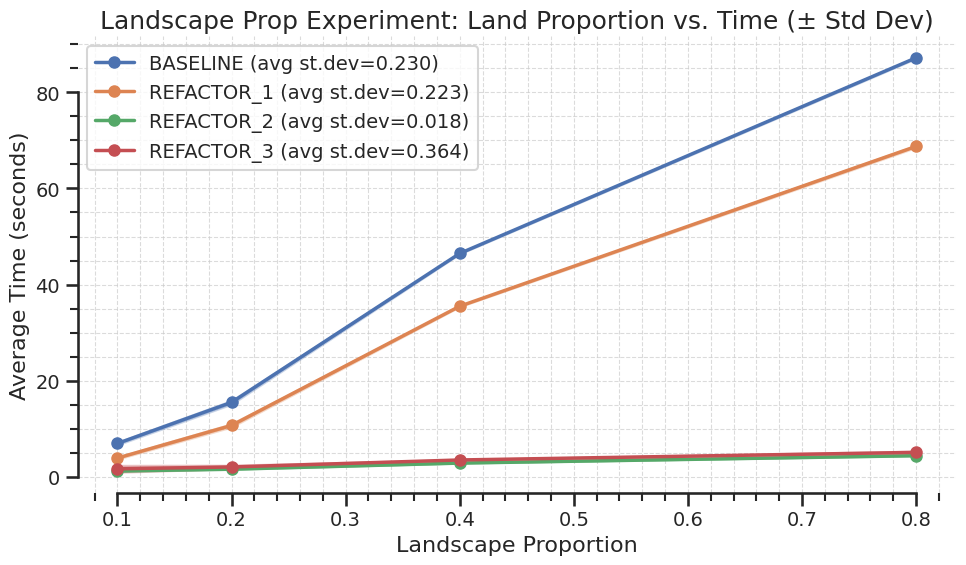

[DEBUG] parse_grid_scaling_results -> Found 4 files in ./grid_scaling
  [DEBUG] approach: REFACTOR_2, dimension: 10x10, times=[0.06085950997658074, 0.05591554311104119, 0.056180356070399284]
    mean_time=0.057651803052673735, std_time=0.002781109357454627
  [DEBUG] approach: REFACTOR_2, dimension: 20x20, times=[0.11183362500742078, 0.1068725980585441, 0.10738067200873047]
    mean_time=0.10869563169156511, std_time=0.0027294296698175988
  [DEBUG] approach: REFACTOR_2, dimension: 40x40, times=[0.3058218489168212, 0.3088774150237441, 0.31456751096993685]
    mean_time=0.309755591636834, std_time=0.004438473477408693
  [DEBUG] approach: REFACTOR_2, dimension: 80x80, times=[1.1028815320460126, 1.1130592409754172, 1.11736730101984]
    mean_time=1.1111026913470898, std_time=0.007438443420962184
  [DEBUG] approach: REFACTOR_2, dimension: 160x160, times=[4.360029281000607, 4.380513905896805, 4.368573840940371]
    mean_time=4.369705675945927, std_time=0.010289108423198842
  [DEBUG] approach:

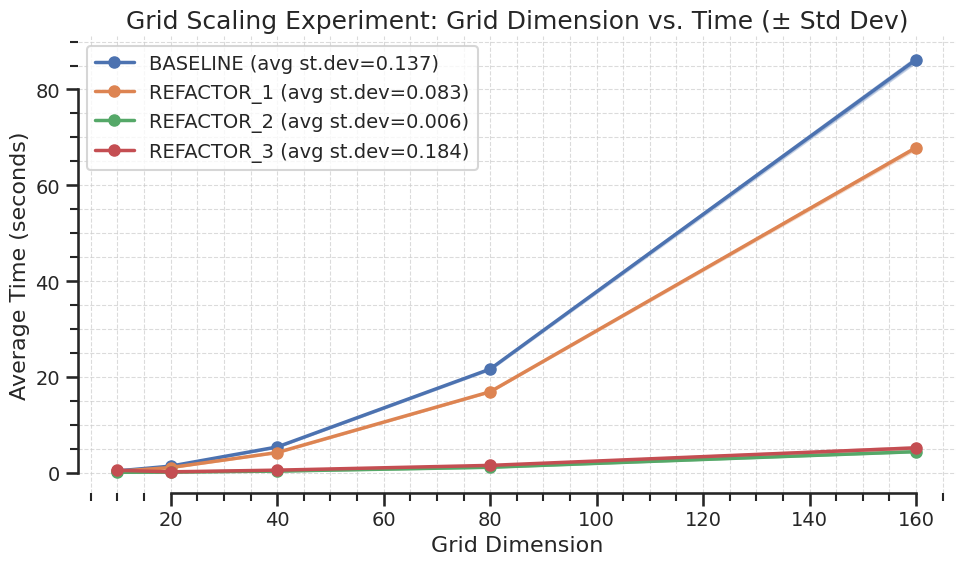

In [4]:
# ─── Cell #4: Main Execution───────────────────────────────

def main(debug: bool = False) -> None:
    """
    Example usage showing how to parse and plot both experiment types.
    Set 'debug=True' to see extra prints of times, means, st.dev, etc.
    """
    BASE_PATH = "."
    # Parse and plot landscape_prop results
    lp_folder = os.path.join(BASE_PATH, "landscape_prop")
    lp_data = parse_landscape_prop_results(lp_folder, debug=debug)
    plot_landscape_prop_results(lp_data)
    plt.show()

    # Parse and plot grid_scaling results
    gs_folder = os.path.join(BASE_PATH, "grid_scaling")
    gs_data = parse_grid_scaling_results(gs_folder, debug=debug)
    plot_grid_scaling_results(gs_data)
    plt.show()


if __name__ == "__main__":
    main(debug=True)


[DEBUG] ./grid_scaling/REFACTOR_2_grid_scaling_Experiment_2.json → 10x10: [0.06085950997658074, 0.05591554311104119, 0.056180356070399284] → mean=0.057651803052673735, std=0.002781109357454627
[DEBUG] ./grid_scaling/REFACTOR_2_grid_scaling_Experiment_2.json → 20x20: [0.11183362500742078, 0.1068725980585441, 0.10738067200873047] → mean=0.10869563169156511, std=0.0027294296698175988
[DEBUG] ./grid_scaling/REFACTOR_2_grid_scaling_Experiment_2.json → 40x40: [0.3058218489168212, 0.3088774150237441, 0.31456751096993685] → mean=0.309755591636834, std=0.004438473477408693
[DEBUG] ./grid_scaling/REFACTOR_2_grid_scaling_Experiment_2.json → 80x80: [1.1028815320460126, 1.1130592409754172, 1.11736730101984] → mean=1.1111026913470898, std=0.007438443420962184
[DEBUG] ./grid_scaling/REFACTOR_2_grid_scaling_Experiment_2.json → 160x160: [4.360029281000607, 4.380513905896805, 4.368573840940371] → mean=4.369705675945927, std=0.010289108423198842
[DEBUG] ./grid_scaling/REFACTOR_2_grid_scaling_Experiment_2

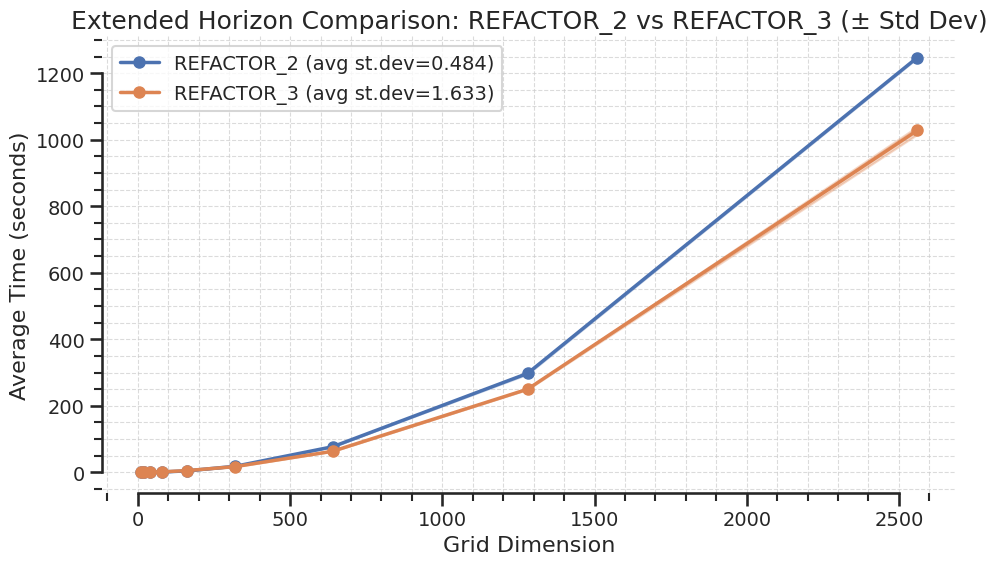

In [5]:
# ─── Cell #5: Extended Horizon Comparison for REFACTOR_2 vs REFACTOR_3 ─────────

def plot_extended_horizon_comparison(debug: bool = False):
    """
    Plots REFACTOR_2 vs REFACTOR_3 over extended grid sizes for Experiment_2.
    Only loads and displays these two files.
    """
    folder_path = os.path.join(BASE_PATH, "grid_scaling")
    ref2_path = os.path.join(folder_path, "REFACTOR_2_grid_scaling_Experiment_2.json")
    ref3_path = os.path.join(folder_path, "REFACTOR_3_grid_scaling_Experiment_2.json")

    def load_and_extract(file_path: str) -> List[Tuple[float, float, int]]:
        with open(file_path, "r") as f:
            data = json.load(f)
        result = []
        for dim_key, prop_dict in data.get("results", {}).items():
            grid_size = int(dim_key.split("x")[0])
            for _, times in prop_dict.items():
                mean_time = statistics.mean(times)
                std_time = statistics.stdev(times) if len(times) > 1 else 0.0
                if debug:
                    print(f"[DEBUG] {file_path} → {dim_key}: {times} → mean={mean_time}, std={std_time}")
                result.append((mean_time, std_time, grid_size))
        return sorted(result, key=lambda x: x[2])  # sort by grid size

    ref2_data = load_and_extract(ref2_path)
    ref3_data = load_and_extract(ref3_path)

    # Plot
    plt.figure()
    for idx, (label, data) in enumerate([("REFACTOR_2", ref2_data), ("REFACTOR_3", ref3_data)]):
        means = [x[0] for x in data]
        stds  = [x[1] for x in data]
        sizes = [x[2] for x in data]
        lower = [m - s for m, s in zip(means, stds)]
        upper = [m + s for m, s in zip(means, stds)]
        avg_std = sum(stds) / len(stds) if stds else 0.0
        legend_label = f"{label} (avg st.dev={avg_std:.3f})"
        plt.plot(sizes, means, '-o', markersize=8, label=legend_label, color=sns.color_palette()[idx])
        plt.fill_between(sizes, lower, upper, alpha=0.3, color=sns.color_palette()[idx])

    plt.title("Extended Horizon Comparison: REFACTOR_2 vs REFACTOR_3 (± Std Dev)")
    plt.xlabel("Grid Dimension")
    plt.ylabel("Average Time (seconds)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.7)
    plt.minorticks_on()
    sns.despine(trim=True)
    plt.tight_layout()
    plt.show()
    
plot_extended_horizon_comparison(debug=True)


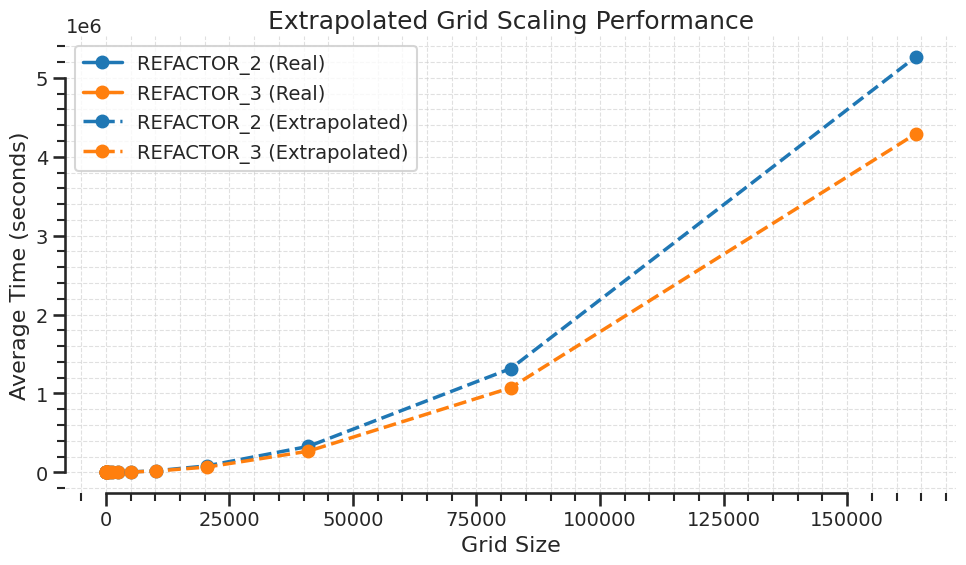

,Grid Size,REFACTOR_2 (s),REFACTOR_3 (s),REFACTOR_2 (h),REFACTOR_3 (h),Diff (s),Diff (h)
0,5120,5.061369e+03,4.147589e+03,1.405936,1.152108,913.779448,0.253828
1,10240,2.040531e+04,1.667225e+04,5.668140,4.631181,3733.055262,1.036960
2,20480,8.194541e+04,6.685705e+04,22.762613,18.571403,15088.356470,4.191210
3,40960,3.284345e+05,2.677686e+05,91.231812,74.380158,60665.957208,16.851655
4,81920,1.315048e+06,1.071759e+06,365.291227,297.710907,243289.151967,67.580320
5,163840,5.262819e+06,4.288411e+06,1461.894120,1191.225366,974407.514623,270.668754


In [6]:
# ─── Cell #6: Extrapolated Performance with Hour Conversions and Differences (Second degree polynomial) ─────────

import os
import json
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

def extrapolate_and_plot() -> None:
    """
    Loads performance data from REFACTOR_2 and REFACTOR_3 JSON files,
    fits a polynomial (degree 3) to the real data, and extrapolates performance
    values for larger grid sizes. It then plots both the real and the extrapolated data,
    and creates a summary table with the extrapolated results in seconds and hours,
    including the computed differences between the two approaches.
    """
    # Define the folder and file paths (using BASE_PATH from Cell #1)
    folder_path = os.path.join(BASE_PATH, "grid_scaling")
    ref2_path = os.path.join(folder_path, "REFACTOR_2_grid_scaling_Experiment_2.json")
    ref3_path = os.path.join(folder_path, "REFACTOR_3_grid_scaling_Experiment_2.json")
    
    # Helper function to load and extract performance data.
    # Returns a list of tuples: (mean_time, std_time, grid_size)
    def load_and_extract(file_path: str) -> list[tuple[float, float, int]]:
        with open(file_path, "r") as f:
            data = json.load(f)
        result = []
        for dim_key, prop_dict in data.get("results", {}).items():
            # Extract grid size from keys like "2560x2560"
            grid_size = int(dim_key.split("x")[0])
            for _, times in prop_dict.items():
                mean_time = statistics.mean(times)
                std_time = statistics.stdev(times) if len(times) > 1 else 0.0
                result.append((mean_time, std_time, grid_size))
        # Sort by grid size
        result.sort(key=lambda tup: tup[2])
        return result
    
    # Load performance data for both approaches.
    ref2_data = load_and_extract(ref2_path)
    ref3_data = load_and_extract(ref3_path)
    
    # Helper function to unpack grid sizes and mean times.
    def unpack(data: list[tuple[float, float, int]]) -> tuple[np.ndarray, np.ndarray]:
        sizes = [t[2] for t in data]
        means = [t[0] for t in data]
        return np.array(sizes), np.array(means)
    
    X2, y2 = unpack(ref2_data)
    X3, y3 = unpack(ref3_data)
    
    # Fit a polynomial to the real data (degree 3, although the header indicates quadratic)
    degree = 2
    poly2 = np.poly1d(np.polyfit(X2, y2, degree))
    poly3 = np.poly1d(np.polyfit(X3, y3, degree))
    
    # Define new (extrapolated) grid sizes.
    extrap_grid_sizes = np.array([5120, 10240, 20480, 40960, 81920, 163840])
    extrap_y2 = poly2(extrap_grid_sizes)
    extrap_y3 = poly3(extrap_grid_sizes)
    
    # Plot the real data and the extrapolated curves.
    plt.figure()
    plt.plot(X2, y2, 'o-', label="REFACTOR_2 (Real)", color='tab:blue')
    plt.plot(X3, y3, 'o-', label="REFACTOR_3 (Real)", color='tab:orange')
    plt.plot(extrap_grid_sizes, extrap_y2, '--o', label="REFACTOR_2 (Extrapolated)", color='tab:blue')
    plt.plot(extrap_grid_sizes, extrap_y3, '--o', label="REFACTOR_3 (Extrapolated)", color='tab:orange')
    
    plt.title("Extrapolated Grid Scaling Performance")
    plt.xlabel("Grid Size")
    plt.ylabel("Average Time (seconds)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.minorticks_on()
    sns.despine(trim=True)
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame for the extrapolated results (in seconds).
    table = pd.DataFrame({
        "Grid Size": extrap_grid_sizes,
        "REFACTOR_2 (s)": extrap_y2,
        "REFACTOR_3 (s)": extrap_y3
    })
    
    # Create columns for hours (seconds divided by 3600).
    table["REFACTOR_2 (h)"] = table["REFACTOR_2 (s)"] / 3600
    table["REFACTOR_3 (h)"] = table["REFACTOR_3 (s)"] / 3600
    
    # Calculate the differences (REFACTOR_2 - REFACTOR_3), in seconds and hours.
    table["Diff (s)"] = table["REFACTOR_2 (s)"] - table["REFACTOR_3 (s)"]
    table["Diff (h)"] = table["Diff (s)"] / 3600
    
    # Display the table with all columns.
    display(table)

# Call the function to produce the plot and display the extrapolation table.
extrapolate_and_plot()
